In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm, pinv
%matplotlib inline
np.set_printoptions(precision=12, suppress=True)

In [2]:
consider_distort = False # flag whether to consider distortion
zoomed_coords = True # whether to divide coordinates by 5 or not (zoomed coords or not)
center_only = True # use only central stars: [w/4; 3w/4], [h/4, 3h/4]
SCALE_FAC = 4.0 # Scale factor of coordinates

In [30]:
coords_folder = 'data/star_coords/2016nov-11_txt/' # folder with coords files
images_folder = 'data/stars/2016nov-11/'
results_folder = 'results/2016nov-11/'

In [4]:
# 20160218
# fnames = [
#     '20160218-201934-437.txt',
#     '20160218-211934-484.txt'
# ]

# 20160219
# fnames = [
#     '20160219-001934-484.txt',
#     '20160219-021934-593.txt',
#     '20160219-041934-593.txt'
# ]

# 20160311
# fnames = [
#     '20160311-020811-125.txt',
#     '20160311-030811-125.txt'
# ]

# 2016nov-11 jpg
fnames = [
    "20161122-191517-359.txt",
    "20161122-201517-375.txt",
    "20161122-211517-375.txt",
    "20161122-221517-375.txt"
]

In [5]:
date = fnames[0][:-4]

In [6]:
if consider_distort:
    print "consider_distort is True!"

In [7]:
im = Image.open(images_folder + "mod_" + date + "-1.jpg")
w, h = im.size
print "Image size:", w, h

Image size: 3072 2304


In [8]:
CENTER_RAD = 600 # radius(px) of central part
x_c, y_c = w/2, h/2 # central point of img

In [9]:
coords_list = []
for fname in fnames:
    piece = np.loadtxt(coords_folder + os.sep + fname)
    coords_list.append(piece)

coords = np.vstack(coords_list)
print 'Zoomed In Star coordinates pairs:\n', coords, '\n'

if zoomed_coords:
    coords /= float(SCALE_FAC)
    coords = coords.round()
    print 'Normal Star coordinates pairs:\n', coords


if center_only:
    coords_center = []
    
    for i in xrange(coords.shape[0]):
        _lx = coords[i, 0]
        _ly = coords[i, 1]
        _rx = coords[i, 2]
        _ry = coords[i, 3]
        if \
        (_lx - x_c)**2 + (_ly - y_c)**2 <= CENTER_RAD**2 and \
        (_rx - x_c)**2 + (_ry - y_c)**2 <= CENTER_RAD**2:
            print coords[i]
            coords_center.append(coords[i])
    
    coords = np.vstack(coords_center)
    print 'Normal Star coordinates pairs in center:\n', coords

Zoomed In Star coordinates pairs:
[[  5734.   6266.   6711.   6411.]
 [  6490.   6723.   7468.   6866.]
 [  5934.   7360.   6910.   7507.]
 [  6209.   7975.   7190.   8129.]
 [  9774.   8478.  10880.   8711.]
 [ 10446.   6163.  11559.   6314.]
 [ 10446.   3421.  11514.   3477.]
 [  8961.   1184.   9917.   1233.]
 [  2774.    834.   3744.   1098.]
 [  2590.   4247.   3603.   4430.]
 [  3413.   3882.   4398.   4059.]
 [  4925.   5164.   5897.   5313.]
 [  5752.   5441.   6722.   5588.]
 [  5350.   6173.   6327.   6316.]
 [  5744.   6692.   6720.   6837.]
 [   559.    205.   1675.    599.]
 [  1301.   3859.   2372.   4068.]
 [  2059.   3306.   3090.   3523.]
 [  9154.   6391.  10192.   6543.]
 [  9394.   4114.  10417.   4210.]
 [  8940.   1459.   9900.   1517.]
 [  7235.   7108.   8228.   7262.]
 [  8046.   7445.   9058.   7613.]
 [  9455.   6441.  10512.   6595.]
 [  8230.   4581.   9217.   4702.]
 [  8051.   2332.   9002.   2428.]
 [  3890.   4262.   4866.   4428.]
 [  4766.   4356.   5

In [10]:
lX = coords[:, 0] # leftX coordinates
lY = coords[:, 1] # leftY coordinates
rX = coords[:, 2] # rightX coordinates
rY = coords[:, 3] # rightY coordinates

N = coords.shape[0] # number of pairs of points
M = coords.shape[1] # lX, lY, rX, rY == 4
print 'Number of Star coordinates pairs:', N

Number of Star coordinates pairs: 12


In [11]:
xi = np.zeros(2*N)

num_coeffs = 6
if consider_distort:
    num_coeffs = 8

z = np.zeros(num_coeffs)
arr = np.zeros((2*N, num_coeffs)) # matrix A
print 'Number of coefficients:', num_coeffs

Number of coefficients: 6


In [12]:
for i in xrange(N): # fill the xi vector
    xi[2*i] = rX[i]
    xi[2*i + 1] = rY[i]

In [13]:
if consider_distort:
    im = Image.open('data/stars/2016nov-11/mod_'+ fnames[0][:-4] +'-1.jpg')
    x_c = im.width / 2.0
    y_c = im.height / 2.0
    for i in xrange(N): # fill the A matrix
        dist_l = (lX[i]-x_c)**2 + (lY[i]-y_c)**2
        dist_r = (rX[i]-x_c)**2 + (rY[i]-y_c)**2

        zx1 = (lX[i] - x_c) * dist_l
        zx2 = (rX[i] - x_c) * dist_r
        arr[2*i] = [lX[i], lY[i], 0, 0, 1, 0, -zx1, zx2]

        zy1 = (lY[i] - y_c) * dist_l
        zy2 = (rY[i] - y_c) * dist_r
        arr[2*i + 1] = [0, 0, lX[i], lY[i], 0, 1, -zy1, zy2]

else:
    for i in xrange(N): # fill the A matrix
        arr[2*i] = [lX[i], lY[i], 0, 0, 1, 0]

        arr[2*i + 1] = [0, 0, lX[i], lY[i], 0, 1]

In [14]:
np.set_printoptions(precision=2, suppress=True)
print 'A:\n', arr, '\n'
print 'xi:\n', xi
np.set_printoptions(precision=12, suppress=True)

A:
[[ 1434.  1566.     0.     0.     1.     0.]
 [    0.     0.  1434.  1566.     0.     1.]
 [ 1231.  1291.     0.     0.     1.     0.]
 [    0.     0.  1231.  1291.     0.     1.]
 [ 1438.  1360.     0.     0.     1.     0.]
 [    0.     0.  1438.  1360.     0.     1.]
 [ 1338.  1543.     0.     0.     1.     0.]
 [    0.     0.  1338.  1543.     0.     1.]
 [ 1436.  1673.     0.     0.     1.     0.]
 [    0.     0.  1436.  1673.     0.     1.]
 [  972.  1066.     0.     0.     1.     0.]
 [    0.     0.   972.  1066.     0.     1.]
 [ 1192.  1089.     0.     0.     1.     0.]
 [    0.     0.  1192.  1089.     0.     1.]
 [ 1132.  1289.     0.     0.     1.     0.]
 [    0.     0.  1132.  1289.     0.     1.]
 [ 1256.  1393.     0.     0.     1.     0.]
 [    0.     0.  1256.  1393.     0.     1.]
 [ 1637.  1413.     0.     0.     1.     0.]
 [    0.     0.  1637.  1413.     0.     1.]
 [ 1753.   753.     0.     0.     1.     0.]
 [    0.     0.  1753.   753.     0.     1.]
 [ 1019

In [15]:
p_arr = pinv(arr)
z = np.dot(p_arr, xi)
print 'Affine coefficients: \n', z

Affine coefficients: 
[   0.993388988328    0.006676593993   -0.010176642858    1.001364275498
  242.79808691157    48.658369075899]


In [16]:
sigma = 2 # 2 pix error
I = np.eye(2*N)

print 'cond(A): ', np.linalg.cond(arr)
proba = (2*N - num_coeffs) / norm( np.dot(I - np.dot(arr, p_arr), xi) )**2
sig_theory = (1 / proba)**0.5

print 'Probability:', proba
print 'Sigma theory:', sig_theory
print 'Sigma practice', sigma

cond(A):  14609.6186715
Probability: 1.13477205714
Sigma theory: 0.938740777651
Sigma practice 2


In [17]:
a = float(z[0])
b = float(z[1])
c = float(z[2])
d = float(z[3])
e = float(z[4])
f = float(z[5])
if consider_distort:
    eps1 = float(z[6])
    eps2 = float(z[7])

In [18]:
if consider_distort:
    # Get rid of distortions on nlImg
    for i in xrange(N): 
        dist_l = (lX[i] - x_c)**2 + (lY[i] - y_c)**2

        zx1 = (lX[i] - x_c) * dist_l
        zy1 = (lY[i] - y_c) * dist_l

#         lX[round(i - eps1*zx1), round(j - eps2*zy1)] = l_pix[i, j]
        lX[i] = lX[i] - eps1 * zx1
        lY[i] = lY[i] - eps1 * zy1
    
    
    # Get rid of distortions on nrImg

    for i in xrange(N): 
        dist_r = (rX[i] - x_c)**2 + (rY[i] - y_c)**2

        zx2 = (rX[i] - x_c) * dist_r
        zy2 = (rY[i] - y_c) * dist_r

#             nr_pix[round(i - eps1*zx2), round(j - eps2*zy2)] = r_pix[i, j]
        rX[i] = rX[i] - eps2 * zx2
        rY[i] = rY[i] - eps2 * zy2


In [19]:
def affine_transform_point(x, y):
    return [b * y + x * a + e , d * y + x * c + f]

In [20]:
# Calc new (affine transformed) points
for i in xrange(N): 
    lX[i], lY[i] = affine_transform_point(lX[i], lY[i])

In [21]:
mse_dist = 0 # MSE of distance
mse_x = 0 # MSE of x
max_d = 0 # Max of distance error

# alignment errors (px) = sqrt( (lX[i] - rX[i])**2 + (lY[i] - rY[i])**2 )
align_errs = np.zeros(N) 
dists = np.zeros(N) # distance from (x_c, y_c) to lX[i], lY[i]

for i in xrange(N):
    mse_dist += (lX[i] - rX[i])**2 + (lY[i] - rY[i])**2
    mse_x += (lX[i] - rX[i])**2
    
    align_errs[i] = np.sqrt((lX[i] - rX[i])**2 + (lY[i] - rY[i])**2)
    dists[i] = np.sqrt((lX[i] - x_c)**2 + (lY[i] - y_c)**2)
    
    if (lX[i] - rX[i])**2 + (lY[i] - rY[i])**2 > max_d:
        max_d = (lX[i] - rX[i])**2 + (lY[i] - rY[i])**2

mse_dist = mse_dist**0.5 / N
mse_x = mse_x**0.5 / N
max_d = max_d**0.5

print 'mse_dist:', mse_dist
print 'mse_x:', mse_x
print 'max_d:', max_d

mse_dist: 0.331894984827
mse_x: 0.21856165629
max_d: 1.91831791311


In [31]:
res_fname = results_folder

if center_only:
    res_fname += 'center_only_CenRad' + str(CENTER_RAD) +"_"

if consider_distort:
    res_fname += 'affdis_coeffs_shots'
else:
    res_fname += 'affine_coeffs_shots'


res_fname += str(len(fnames)) + '_' + fnames[0]

In [32]:
np.savetxt(res_fname, z, fmt="%.12f")
print 'Coeffs are saved to:', res_fname

Coeffs are saved to: results/2016nov-11/center_only_CenRad600_affine_coeffs_shots4_20161122-191517-359.txt


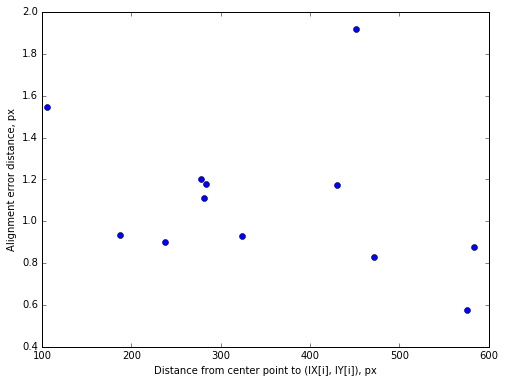

In [38]:
if center_only:
    plt.figure(figsize=(8,6))
    plt.plot(dists, align_errs, 'o')
    plt.xlabel('Distance from center point to (lX[i], lY[i]), px')
    plt.ylabel('Alignment error distance, px')
    plt.savefig(res_fname[:-4] + '_plot_AlignErr_from_Distance')